# Introduction to Convolutional Neural Network (CNN) PART III
> Explains ResNet models and it's training on Imagenette Dataset.
- toc: true 
- badges: true
- comments: true

## Introduction
We have seen the working of a simple CNN on MNIST dataset in previous posts. We have also noticed that CNN gives far better accuracy than a simple Neural Network on image related tasks. For more complex datasets we need to have much deeper CNNs, with layers even >100. Issue with deeper networks is that gradient flow during backpropagation is poor and so it needs additional Batch Normalisation (I will explain in depth in a post dedicated to BN) layers. Even after adding BN layers to smooth the grad flows it's been notices that deeper NN have less training/validation accuracies than their shallower counterparts.

If we think in terms of the power of fitting a complex function by a NN, we can say
that this power increases when a network gets deeper. Suppose a shallow NN is able to
achieve some accuracy for a problem then there exists a solution by construction to the
deeper NN where the added layers are identity mappings and other layers are the same
as learned by shallow NN. The existence of the solution by construction means that any
deeper NN shouldn’t have more training/Val loss than the shallower one.

The motivation of ResNet is that the deeper NN is having difficulty in learning identity mappings (same output by a layer as input) because if it was able to learn it then the deeper NN should have at least the accuracy of shallower NN. To ease the learning of identity mappings shortcut connections are added. 
If say there are few layers stacked, and the desired mapping is $\mathcal{H}(x)$, where $x$ is the input to the first layer. Instead of letting the layers fit the $\mathcal{H}(x)$, we let these layers fit a residual mapping $\mathcal{F}(x) = \mathcal{H}(x) - x$, and then the x from input is added to this new mapping. Adding x to the output of the next 2-3 layers is done by adding a shortcut connection. Introducing shortcut connections after every 2-3 layers add no extra parameter to the NN.

With addition of shortcut connection, learning identity mappings is easier because now the NN has to just push the weights of layers to 0, and experiments indicate that it's easier to do this than the earlier case.

## Dataset
We have used MNIST dataset in the last post, but that dataset is very simple so even without much effort we got 0.99 accuracy. For ResNets, to see their potential we will train and predict on a much more complex dataset, the [Imagentte](https://github.com/fastai/imagenette). 

In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

/home/nitish/miniconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In the below function get_data it returns a dataloader with bs=128. It's taken from the fast.ai tutorials, I will explain about the augmentations in some later post.

In [17]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [18]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

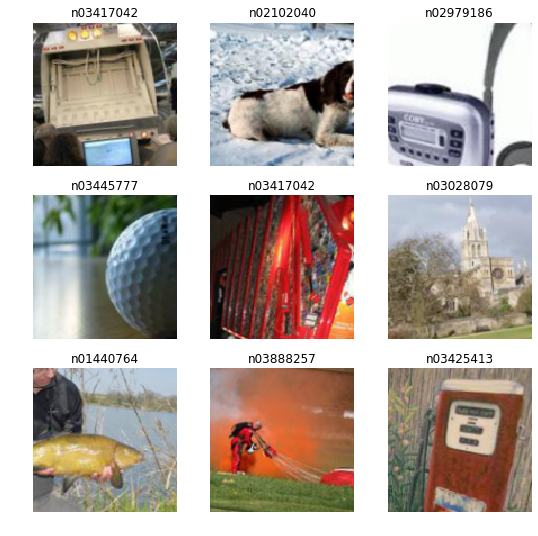

In [19]:
dls.show_batch()

In [22]:
print(f'shape of 1 batch is {first(dls.train)[0].shape} and labels shape is {first(dls.train)[1].shape}')

shape of 1 batch is (128, 3, 128, 128) and labels shape is (128,)


Each image is a grid of 128x128 with 3 channels. Now we can't simply use the simplistic approach of the last post's CNN where we keep on using stride=2 until the grid size becomes very small or becomes 1x1 because:
1. If the image size is big it will take lot of layers, which would be more than we want to have stride-2 layers.
1. I won't accept any input image of other dimension.
So what we can do is use `AdaptiveAvgPool2d` after sometime.

In [23]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)

def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),    #1x1
        Flatten(),
        nn.Linear(256, dls.c)) 

In [26]:
learn = Learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.005248074419796467)

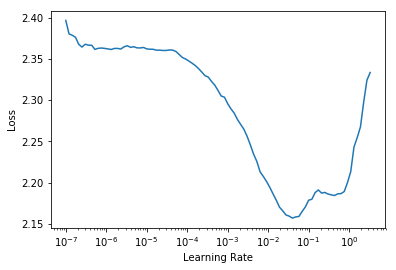

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.998753,1.856944,0.316178,01:10
1,1.662375,1.605197,0.483057,01:14
2,1.438419,1.418045,0.551847,01:20
3,1.283973,1.262218,0.597707,01:19
4,1.220046,1.246183,0.606115,01:17


Lets create a block of ResNet. In the below code, block is of 2 conv layers, and in forward pass we add the input x with the output of the block and passes it through an activation function.

In [45]:
class ResNetBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.block = nn.Sequential(ConvLayer(ni, nf, 3, stride=stride), ConvLayer(nf, nf, 3, act_cls=None))
    def forward(self, x):
        return F.relu(x + self.block(x))

There is one very drastic problem here, we have to have ni==nf, and stride=1, otherwise x and output of block won't have same dimensions and therefore won't add. To overcome this issue we can add projection matrix when ni!=nf, and pooling  layer when stride=2.

In [46]:
class ResNetBlock(Module):
    def __init__(self, ni, nf, stride=2):
        self.block = nn.Sequential(ConvLayer(ni, nf, 3, stride=stride), ConvLayer(nf, nf, 3, act_cls=None))
        self.proj = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2)
    def forward(self, x):
        return F.relu(self.proj(self.pool(x)) + self.block(x))    

In [97]:
def block(ni, nf, stride=2): return ResNetBlock(ni,nf,stride)

In [51]:
learn = Learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0014454397605732083)

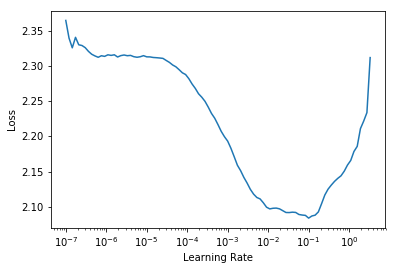

In [53]:
learn.lr_find()
# get_model()

In [54]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.763220,1.874107,0.401529,02:32
1,1.388270,1.285148,0.578853,02:44
2,1.137202,1.181905,0.604331,02:43
3,0.955591,0.927090,0.707261,02:53
4,0.870883,0.902563,0.713631,02:49


We have been able to achieve far better accuracy of 0.71 with ResNets as compared to 0.60 accuracy of regular CNN. But can we do better, yes we can. We can built a deeper ResNets (with some tweaks to help in deeper models).

In any CNN, the number of computations in the initial layers is more than in the deeper layers, and number of paramters in the deeper layers are more than in initial layers. So that's why the initial layers of deep CNNs are kept fairly fast and simple, and these intial layers are known as stem.

In [70]:
def stem(sizes):
    return [ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1) for i in range(len(sizes) - 1)
            ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [102]:
stem([3, 32,64])

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [123]:
class ResNetModel(Module):
    def __init__(self, n_layers=[2,2,2,2], stem_sizes=[3,32,64]):
        self.stem = stem([3,32,64])
        self.channels = [64,64,128,256,512]
#         self.blocks = [add_multi_blockss(self.channels[i], self.channels[i+1]) for i in range(len(self.channels)-1)]
        self.blocks = [add_multi_blocks(self.channels[i], self.channels[i+1], n_layers[i]) for i in range(len(self.channels)-1)]
        self.model = nn.Sequential(*self.stem, *self.blocks, nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512,10))
        
    def forward(self, x):
        return self.model(x)
    
def add_multi_blocks(ci, co, n_blocks):
    return nn.Sequential(*[block(ci if i==0 else co, co, stride=2 if i==0 else 1) for i in range(n_blocks)])

def add_multi_blockss(ci, co):
    return block(ci,co)

In [125]:
ResNetModel()

ResNetModel(
  (model): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): ResNetBlock(
        (block): Sequential(
          (0): ConvLayer(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (1): ConvLayer(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [124]:
learn = Learner(dls, ResNetModel(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [126]:
learn.lr_find()

KeyboardInterrupt: 

In [75]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.625003,1.526519,0.496306,04:03
1,1.265496,1.084301,0.648662,04:12
2,1.056175,1.117462,0.640764,04:13
3,0.898983,0.911441,0.711847,04:15
4,0.746213,0.800660,0.747516,04:14
